# model.ipynb: 建立训练集

In [117]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import torch
import joblib
from sklearn import preprocessing
%matplotlib inline
from sklearn import ensemble
from utils import loadData
from sklearn.neural_network import MLPRegressor
from utils import loadData, getNum, getCancel, saveData, saveans, wavelet_denoising
from tqdm import tqdm
import graphviz
import lightgbm as lgb

`tkeo`函数，作用不明

In [118]:
def tkeo(arr):
    arr = arr.reshape(-1, 1000)
    tkeo = np.copy(arr)
    # Teager–Kaiser Energy operator
    tkeo[:, 1:-1] = arr[:, 1:-1]*arr[:, 1:-1] - arr[:, :-2]*arr[:, 2:]
    # correct the data in the extremities
    tkeo[:, 0], tkeo[:, -1] = tkeo[:, 1], tkeo[:, -2]
    return(tkeo)

指定__测试集__，__训练集__，__几何文件__的位置

In [119]:
testpath = "./data/final.h5"
trainpath = "./data/final-2.h5"
geopath = "./data/geo.h5"

读取__训练集__：

In [120]:
trainPET, trainWF, trainPT = loadData(trainpath, 'PT')

Structure of data:
<HDF5 dataset "PETruth": shape (9222643,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6021458,), type "|V2008"> Waveform /Waveform


读取__测试集__，这里只读取Waveform

In [5]:
testWF = loadData(testpath, 'test')

Structure of data:
<HDF5 dataset "Waveform": shape (12178193,), type "|V2008"> Waveform /Waveform


在训练集的PETruth中，找到所有的EventID以及其对应的index，并且找出所有的Event对应的PE数。\
这与训练集的Waveform的维数并不相同。`numPET`表示每个EventID对应的PE数，`numPEW`表示每个EventID对应的波形数。\
两者需要处理两遍，但方法是一致的。

In [198]:
numPET, pe_indices = getNum(trainPET)
numPEW, wf_indices = getNum(trainWF)

pePerWF = np.array([])
splitWFChannels = np.split(trainWF['ChannelID'], wf_indices[1:-1])
for index, arr in enumerate(tqdm(np.split(trainPET['ChannelID'], pe_indices[1:-1]))):
    channels, counts = np.unique(arr, return_counts=True)
    # indicesToInsert = np.isin(splitWFChannels[index], channels, invert=True).nonzero()[0]
    # for indexToInsert in indicesToInsert:
        # counts = np.insert(counts, indexToInsert, 0)
    zeroPeChannelCount = numPEW[index].astype(int) - channels.shape[0]
    while zeroPeChannelCount:
        alignedChannels = np.append(channels, np.zeros(zeroPeChannelCount)-1)
        indexToInsert = np.asarray(alignedChannels != splitWFChannels[index]).nonzero()[0][0]
        channels = np.insert(channels, indexToInsert, splitWFChannels[index][indexToInsert])
        counts = np.insert(counts, indexToInsert, 0)
        zeroPeChannelCount -= 1
    
    pePerWF = np.append(pePerWF, counts)

pePerWF = pePerWF.flatten().astype(int)
peTimesPerWF = np.split(trainPET['PETime'], np.cumsum(pePerWF))[:-1]
print(pePerWF.shape)
print(len(peTimesPerWF))
print(trainWF.shape)

100%|██████████| 2000/2000 [00:06<00:00, 314.48it/s]


(6021458,)
6021458
(6021458,)


去除噪声的WF：设置下限为918，小于918的认为是有意义的信息，大于等于918的认为是噪声。\
下面去除噪声，并且随便取一个WF作图：

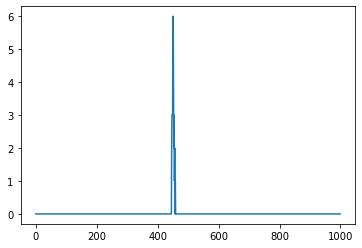

In [140]:
denoisedTrainWF = np.where(trainWF['Waveform'] < 918, 918-trainWF['Waveform'], 0)

In [826]:
def getPETime(args):
    point_judge, int_judge, cancel_max, noise_thre, point_minus, int_minus = args
    right = 0
    for i in range(10000):
        randIndex = i
        #print(f"这是第{randIndex}个波形")
        #print(f"PETruth告诉我们有{pePerWF[randIndex]}个光电子")
        #print(f"PETruth告诉我们PETime是{peTimesPerWF[randIndex]}")
        cancelledTrainWF = denoisedTrainWF[randIndex]
        wfArgmax = np.array([])

        points_more_than_threshold = cancelledTrainWF.nonzero()[0].shape[0]
        #print(f"多于阈值的点有{points_more_than_threshold}个")
        integrate = np.sum(cancelledTrainWF)
        #print(f"积分为{integrate}")
        while points_more_than_threshold >= point_judge or integrate >= int_judge:
            argmax = np.argmax(cancelledTrainWF)
            wfArgmax = np.append(wfArgmax, argmax)
            cancelledTrainWF = cancelledTrainWF - getCancel(argmax, cancel_max)
            judge_noise = cancelledTrainWF[argmax-8:argmax+9]
            judge_noise = np.where(np.abs(judge_noise) < noise_thre, 0, judge_noise)
            cancelledTrainWF[argmax-8:argmax+9] = judge_noise
            
            points_more_than_threshold -= point_minus
            # integrate -= int_minus
            # points_more_than_threshold = cancelledTrainWF.nonzero()[0].shape[0]
            integrate = np.sum(cancelledTrainWF)

        #print(wfArgmax)
        #plt.plot(denoisedTrainWF[randIndex])
        #plt.show()
        right += int(wfArgmax.shape[0] == pePerWF[randIndex])
    return -right

right = 0
for randIndex in tqdm(range(1000000)):
    cancelledTrainWF = denoisedTrainWF[randIndex]
    wfArgmax = np.array([])

    points_more_than_threshold = cancelledTrainWF.nonzero()[0].shape[0]
    # print(f"多于阈值的点有{points_more_than_threshold}个")
    integrate = np.sum(cancelledTrainWF)
    # print(f"积分为{integrate}")
    init_integrate = np.sum(cancelledTrainWF)
    init_points = cancelledTrainWF.nonzero()[0].shape[0]
    first = True
    while (points_more_than_threshold >= 12 or integrate >= 120 or first) \
            and ((wfArgmax.shape[0]+1)*120 < init_integrate or (wfArgmax.shape[0]+1)*12 < init_points or first)\
            and (wfArgmax.shape[0] or init_points >= 4 or init_integrate >= 60):
        argmax = np.argmax(cancelledTrainWF)
        wfArgmax = np.append(wfArgmax, argmax)
        cancelledTrainWF = cancelledTrainWF - getCancel(argmax, 10)
        judge_noise = cancelledTrainWF[argmax-8:argmax+9]
        judge_noise = np.where(judge_noise < 6, 0, judge_noise)
        cancelledTrainWF[argmax-8:argmax+9] = judge_noise 
        points_more_than_threshold = cancelledTrainWF.nonzero()[0].shape[0]
        integrate = np.sum(cancelledTrainWF)
        first = False
    right += int(wfArgmax.shape[0] == pePerWF[randIndex])

print(right)


100%|██████████| 1000000/1000000 [02:04<00:00, 8054.06it/s]

900262


这是第4857617个波形
PETruth告诉我们有1个光电子
PETruth告诉我们PETime是[373.70351947]
多于阈值的点有17个
积分为75
[388.]


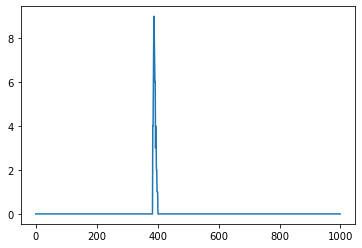

In [809]:
randIndex = np.random.randint(0, denoisedTrainWF.shape[0]-1)
# randIndex = 4388191 #
# randIndex = 4880157 #需要初始
# randIndex = 5886548 #太多了
# randIndex = 5186074
# randIndex = 3793364
# randIndex = 3218203
# randIndex = 690724
# randIndex = 3552877
print(f"这是第{randIndex}个波形")
print(f"PETruth告诉我们有{pePerWF[randIndex]}个光电子")
print(f"PETruth告诉我们PETime是{peTimesPerWF[randIndex]}")
cancelledTrainWF = denoisedTrainWF[randIndex]
wfArgmax = np.array([])

points_more_than_threshold = cancelledTrainWF.nonzero()[0].shape[0]
print(f"多于阈值的点有{points_more_than_threshold}个")
integrate = np.sum(cancelledTrainWF)
print(f"积分为{integrate}")
init_integrate = np.sum(cancelledTrainWF)
init_points = cancelledTrainWF.nonzero()[0].shape[0]
first = True
while (points_more_than_threshold >= 10 or integrate >= 100 or first) \
        and ((wfArgmax.shape[0]+1)*120 < init_integrate or (wfArgmax.shape[0]+1)*12 < init_points or first)\
        and (wfArgmax.shape[0] or init_points >= 4 or init_integrate >= 60):
    argmax = np.argmax(cancelledTrainWF)
    wfArgmax = np.append(wfArgmax, argmax)
    cancelledTrainWF = cancelledTrainWF - getCancel(argmax, 10)
    judge_noise = cancelledTrainWF[argmax-8:argmax+9]
    judge_noise = np.where(judge_noise < 6, 0, judge_noise)
    cancelledTrainWF[argmax-8:argmax+9] = judge_noise 
    points_more_than_threshold = cancelledTrainWF.nonzero()[0].shape[0]
    integrate = np.sum(cancelledTrainWF)
    first = False

print(wfArgmax)
plt.plot(denoisedTrainWF[randIndex])
plt.show()


In [708]:
from hyperopt import fmin, tpe, hp
best = fmin(
    fn=getPETime,
    space=[
        hp.uniform('point_judge', 0, 10),
        hp.uniform('int_judge', 60, 200),
        hp.uniform('cancel_max', 10, 25),
        hp.uniform('noise_thre', 0, 10),
        hp.uniform('point_minus', 10, 30),
        hp.uniform('int_minus', 100, 200),
    ],
    algo=tpe.suggest,
    max_evals=100)
print(best)

  3%|▎         | 3/100 [00:03<01:54,  1.18s/trial, best loss: -8661.0]


KeyboardInterrupt: 

In [308]:
intWF = np.sum(denoisedTrainWF, axis=1)
plt.scatter(pePerWF[:1000], intWF[:1000])
plt.show()

KeyboardInterrupt: 

ValueError: x and y must be the same size

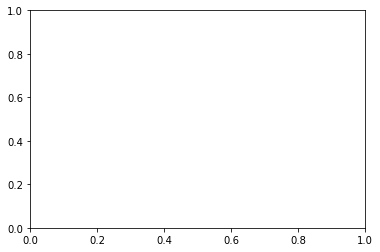

In [149]:
# thres = 300
intWFPerEvent = np.empty(2000)
numFiltered = np.array([])
for index, arr in enumerate(tqdm(np.split(denoisedTrainWF, wf_indices[1:-1]))):

    # arr = wavelet_denoising(arr)

    # head = np.mean(arr[:, :100], axis=1)
    # tail = np.mean(arr[:, -100:], axis=1)
    # base = np.minimum(head, tail)
    # intpWF = np.sum(arr, axis=1)-tail*1000
    # filtered = np.maximum(intpWF, thres)
    # numFiltered = np.sum(filtered==thres)
    # intWF = np.append(intWF, np.sum(filtered)-numFiltered*thres)
    intWFPerEvent[index] = np.sum(arr)

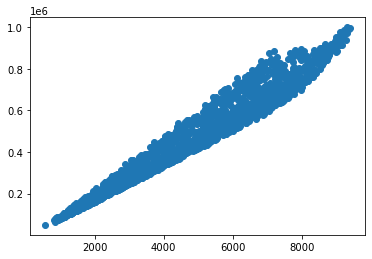

In [17]:
plt.scatter(numPET, intWF)
#plt.plot(trainPT[:, -2], numPEW*4)
plt.show()

In [19]:
train_data_from_int_to_numPET = lgb.Dataset(intWF[:-100].reshape(-1, 1), label=numPET[:-100])
validation_data_from_int_to_numPET = lgb.Dataset(
    intWF[-100:].reshape(-1, 1), numPET[-100:], reference=train_data_from_int_to_numPET
)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 2**11,
    'learning_rate': 0.01,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'verbose': 0,
    'num_threads': 20,
    'max_depth': 11,
}
gbm_from_int_to_numPET = lgb.train(params,
                                   train_data_from_int_to_numPET,
                                   num_boost_round=3000,
                                   valid_sets=validation_data_from_int_to_numPET,
                                   early_stopping_rounds=300)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 2323.01
Training until validation scores don't improve for 300 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 2300.73
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 2278.67
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 2256.86
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 2235.27
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 2213.89
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's rmse: 2192.77
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[147]	valid_0's rmse: 702.878
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[148]	valid_0's rmse: 698.967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[149]	valid_0's rmse: 695.151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	valid_0's rmse: 691.385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[151]	valid_0's rmse: 687.659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[152]	valid_0's rmse: 683.942
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[153]	valid_0's rmse: 680.343
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[154]	valid_0's rmse: 676.804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[155]	valid_0's rmse: 673.302
[LightGBM] [Warning] No further splits with positive ga

[234]	valid_0's rmse: 518.75
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[235]	valid_0's rmse: 517.857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[236]	valid_0's rmse: 516.987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[237]	valid_0's rmse: 516.142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[238]	valid_0's rmse: 515.305
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[239]	valid_0's rmse: 514.473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[240]	valid_0's rmse: 513.604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[241]	valid_0's rmse: 512.833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[242]	valid_0's rmse: 512.047
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[243]	valid_0's rmse: 511.289
[LightGBM] [Warning] No fu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[320]	valid_0's rmse: 480.283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[321]	valid_0's rmse: 480.09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[322]	valid_0's rmse: 479.935
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[323]	valid_0's rmse: 479.775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[324]	valid_0's rmse: 479.614
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[325]	valid_0's rmse: 479.452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[326]	valid_0's rmse: 479.294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[327]	valid_0's rmse: 479.145
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[328]	valid_0's rmse: 479.008
[LightGBM] [Warning] No further splits with positive gai

[404]	valid_0's rmse: 473.349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[405]	valid_0's rmse: 473.351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[406]	valid_0's rmse: 473.341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[407]	valid_0's rmse: 473.336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[408]	valid_0's rmse: 473.334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[409]	valid_0's rmse: 473.325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[410]	valid_0's rmse: 473.255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[411]	valid_0's rmse: 473.27
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[412]	valid_0's rmse: 473.239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[413]	valid_0's rmse: 473.213
[LightGBM] [Warning] No fu

[489]	valid_0's rmse: 473.321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[490]	valid_0's rmse: 473.329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[491]	valid_0's rmse: 473.341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[492]	valid_0's rmse: 473.341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[493]	valid_0's rmse: 473.341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[494]	valid_0's rmse: 473.349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[495]	valid_0's rmse: 473.35
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[496]	valid_0's rmse: 473.366
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[497]	valid_0's rmse: 473.379
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[498]	valid_0's rmse: 473.361
[LightGBM] [Warning] No fu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[589]	valid_0's rmse: 473.555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[590]	valid_0's rmse: 473.583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[591]	valid_0's rmse: 473.568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[592]	valid_0's rmse: 473.56
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[593]	valid_0's rmse: 473.556
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[594]	valid_0's rmse: 473.546
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[595]	valid_0's rmse: 473.575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[596]	valid_0's rmse: 473.563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[597]	valid_0's rmse: 473.587
[LightGBM] [Warning] No further splits with positive gai

[728]	valid_0's rmse: 474.57
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[729]	valid_0's rmse: 474.597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[730]	valid_0's rmse: 474.603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[731]	valid_0's rmse: 474.629
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[732]	valid_0's rmse: 474.638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[733]	valid_0's rmse: 474.645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[734]	valid_0's rmse: 474.625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[735]	valid_0's rmse: 474.607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[736]	valid_0's rmse: 474.632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[737]	valid_0's rmse: 474.643
[LightGBM] [Warning] No fu

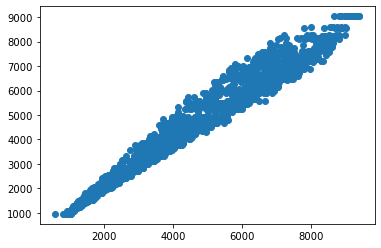

In [19]:
intMaxWF = np.empty(2000)
for index, arr in enumerate(tqdm(np.split(invTrainWF, j_tru[1:-1]))):
    intMaxWF[index] = np.sum(np.max(arr, axis=1))

100%|██████████| 2000/2000 [00:06<00:00, 294.50it/s]


In [81]:
intTKEOWF = np.array([])
for arr in tqdm(np.split(invTrainWF, j_tru[1:-1])):
    intTKEOWF = np.append(intTKEOWF, np.sum(tkeo(arr)))

100%|██████████| 2000/2000 [00:19<00:00, 102.38it/s]


In [20]:
intWFt = np.empty(2000)
for index, arr in enumerate(tqdm(np.split(invTrainWF, j_tru[1:-1]))):
    intWFt[index] = np.sum(arr*(np.arange(1000)+1))-np.sum(np.mean(arr[:, -20:], axis=1)*1000*999/2)

2000it [00:23, 85.70it/s] 


In [1]:
numPEWtest, indicesTest = getNumPerEvent(testWF)
denoisedTestWF = testWF[np.asarray(testWF['Waveform'] < 918).nonzero()]
# denoisedTestWF = np.where(testWF['Waveform'] < 918, 918-testWF['Waveform'], 0)

NameError: name 'np' is not defined

In [121]:
intWFtest = np.empty(2000)
# numFilteredTest = np.array([])
for arr in tqdm(np.split(invTestWF, j_test[1:-1])):
    # head = np.mean(arr[:, :100], axis=1)
    # tail = np.mean(arr[:, -100:], axis=1)
    # base = np.minimum(head, tail)
    # intpWF = np.sum(arr, axis=1)-tail*1000
    # filtered = np.maximum(intpWF, thres)
    # numFiltered = np.sum(filtered==thres)
    # intWFtest = np.append(intWFtest, np.sum(filtered)-numFiltered*thres)
# numPEWtest = numPEWtest - numFilteredTest

100%|██████████| 4000/4000 [00:21<00:00, 189.20it/s]


In [23]:
intMaxWFtest = np.array([])
for arr in tqdm(np.split(invTestWF, j_test[1:-1])):
    intMaxWFtest = np.append(intMaxWFtest, np.sum(np.max(arr, axis=1)))

100%|██████████| 4000/4000 [00:13<00:00, 303.02it/s]


In [92]:
intTKEOWFtest = np.array([])
for arr in tqdm(np.split(invTestWF, j_test[1:-1])):
    intTKEOWFtest = np.append(intTKEOWFtest, np.sum(tkeo(arr)))

100%|██████████| 4000/4000 [00:37<00:00, 106.47it/s]


In [11]:
intWFtTest = np.array([])
for arr in tqdm(np.split(invTestWF, j_test[1:-1])):
    intWFtTest = np.append(intWFtTest, np.sum(arr*(np.arange(1000)+1))-np.sum(np.mean(arr[:, -200:], axis=1)*1000*999/2))

100%|██████████| 4000/4000 [00:35<00:00, 111.12it/s]


In [94]:
Xtest = np.hstack((numPEWtest.reshape(-1, 1), intWFtest.reshape(-1, 1), intMaxWFtest.reshape(-1, 1), intTKEOWFtest.reshape(-1,1)))

In [13]:
saveData(Xtest, np.array([0]), './data/testv3.h5')

In [60]:
Xtest, _ = loadData('./data/testv3.h5', 'pro')

In [25]:
X1 = np.hstack((numPEW.reshape(-1, 1), intWF.reshape(-1, 1)))#intMaxWF.reshape(-1,1), intTKEOWF.reshape(-1,1)))
Y1 = trainPT['vis_photons']

In [26]:
saveData(X1, trainPT, './train/train1.h5')

In [27]:
X1, Y1 = loadData('./data/train1.h5', 'pro')

OSError: Unable to open file (unable to open file: name = './data/train1.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [28]:
train_data1 = lgb.Dataset(X1[:-100], label=Y1[:-100])
validation_data1 = lgb.Dataset(np.array(X1[-100:]), np.array(Y1[-100:]), reference=train_data1)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 2**11,
    'learning_rate': 0.01,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'verbose': 0,
    'num_threads': 20,
    'max_depth': 11,
}
gbm1 = lgb.train(params,
                 train_data1,
                 num_boost_round=3000,
                 valid_sets=validation_data1,
                 early_stopping_rounds=300)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 14727.9
Training until validation scores don't improve for 300 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 14582.1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 14437.9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 14295.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 14153.9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 14014.4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's rmse: 13875.8
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[169]	valid_0's rmse: 2950.77
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[170]	valid_0's rmse: 2924.87
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[171]	valid_0's rmse: 2899.22
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[172]	valid_0's rmse: 2873.91
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[173]	valid_0's rmse: 2848.92
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[174]	valid_0's rmse: 2824.21
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[175]	valid_0's rmse: 2799.74
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[176]	valid_0's rmse: 2775.4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[177]	valid_0's rmse: 2751.25
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[253]	valid_0's rmse: 1549.75
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[254]	valid_0's rmse: 1540.36
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[255]	valid_0's rmse: 1531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[256]	valid_0's rmse: 1521.8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[257]	valid_0's rmse: 1512.88
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[258]	valid_0's rmse: 1503.8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[259]	valid_0's rmse: 1495.06
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[260]	valid_0's rmse: 1486.12
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[261]	valid_0's rmse: 1477.29
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[341]	valid_0's rmse: 1060.57
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[342]	valid_0's rmse: 1057.77
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[343]	valid_0's rmse: 1055.07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[344]	valid_0's rmse: 1052.28
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[345]	valid_0's rmse: 1049.68
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[346]	valid_0's rmse: 1047.09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[347]	valid_0's rmse: 1044.38
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[348]	valid_0's rmse: 1041.94
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[349]	valid_0's rmse: 1039.36
[LightGBM] [Warning] No further splits with positive ga

[420]	valid_0's rmse: 940.729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[421]	valid_0's rmse: 939.961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[422]	valid_0's rmse: 939.336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[423]	valid_0's rmse: 938.413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[424]	valid_0's rmse: 937.611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[425]	valid_0's rmse: 937.007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[426]	valid_0's rmse: 936.053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[427]	valid_0's rmse: 935.584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[428]	valid_0's rmse: 934.72
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[429]	valid_0's rmse: 934.266
[LightGBM] [Warning] No fu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[514]	valid_0's rmse: 905.912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[515]	valid_0's rmse: 905.828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[516]	valid_0's rmse: 905.415
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[517]	valid_0's rmse: 905.399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[518]	valid_0's rmse: 905.308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[519]	valid_0's rmse: 904.768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[520]	valid_0's rmse: 904.681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[521]	valid_0's rmse: 904.595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[522]	valid_0's rmse: 904.406
[LightGBM] [Warning] No further splits with positive ga

[601]	valid_0's rmse: 891.506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[602]	valid_0's rmse: 891.62
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[603]	valid_0's rmse: 891.737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[604]	valid_0's rmse: 891.852
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[605]	valid_0's rmse: 891.996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[606]	valid_0's rmse: 892.116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[607]	valid_0's rmse: 892.251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[608]	valid_0's rmse: 892.432
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[609]	valid_0's rmse: 892.446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[610]	valid_0's rmse: 892.458
[LightGBM] [Warning] No fu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[724]	valid_0's rmse: 885.606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[725]	valid_0's rmse: 885.645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[726]	valid_0's rmse: 885.566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[727]	valid_0's rmse: 885.574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[728]	valid_0's rmse: 885.397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[729]	valid_0's rmse: 885.396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[730]	valid_0's rmse: 885.319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[731]	valid_0's rmse: 885.242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[732]	valid_0's rmse: 885.167
[LightGBM] [Warning] No further splits with positive ga

[877]	valid_0's rmse: 884.897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[878]	valid_0's rmse: 884.885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[879]	valid_0's rmse: 885.026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[880]	valid_0's rmse: 884.908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[881]	valid_0's rmse: 884.896
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[882]	valid_0's rmse: 884.865
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[883]	valid_0's rmse: 884.719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[884]	valid_0's rmse: 884.739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[885]	valid_0's rmse: 884.821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[886]	valid_0's rmse: 884.903
[LightGBM] [Warning] No f

[1033]	valid_0's rmse: 885.741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1034]	valid_0's rmse: 885.837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1035]	valid_0's rmse: 885.712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1036]	valid_0's rmse: 885.724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1037]	valid_0's rmse: 885.729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1038]	valid_0's rmse: 885.827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1039]	valid_0's rmse: 885.708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1040]	valid_0's rmse: 885.75
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1041]	valid_0's rmse: 885.646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1042]	valid_0's rmse: 885.651
[LightGBM] [Warn

In [29]:
X2 = np.hstack((X1, gbm1.predict(X1).reshape(-1,1)))
Y2 = numPET

In [30]:
train_data2 = lgb.Dataset(X2[:-100], label=Y2[:-100])
validation_data2 = lgb.Dataset(np.array(X2[-100:]), np.array(Y2[-100:]), reference=train_data2)
gbm2 = lgb.train(params,
                train_data2,
                num_boost_round=3000,
                valid_sets=validation_data2,
                early_stopping_rounds=300)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 2322.35
Training until validation scores don't improve for 300 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 2299.43
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 2276.69
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 2254.2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 2231.97
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 2209.85
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's rmse: 2188
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[151]	valid_0's rmse: 530.883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[152]	valid_0's rmse: 525.768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[153]	valid_0's rmse: 520.712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[154]	valid_0's rmse: 515.711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[155]	valid_0's rmse: 510.743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[156]	valid_0's rmse: 505.843
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[157]	valid_0's rmse: 500.981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[158]	valid_0's rmse: 496.197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[159]	valid_0's rmse: 491.407
[LightGBM] [Warning] No further splits with positive ga

[237]	valid_0's rmse: 235.87
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[238]	valid_0's rmse: 233.75
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[239]	valid_0's rmse: 231.678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[240]	valid_0's rmse: 229.605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[241]	valid_0's rmse: 227.572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[242]	valid_0's rmse: 225.552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[243]	valid_0's rmse: 223.564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[244]	valid_0's rmse: 221.593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[245]	valid_0's rmse: 219.653
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[246]	valid_0's rmse: 217.687
[LightGBM] [Warning] No fur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[323]	valid_0's rmse: 118.188
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[324]	valid_0's rmse: 117.408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[325]	valid_0's rmse: 116.643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[326]	valid_0's rmse: 115.879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[327]	valid_0's rmse: 115.132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[328]	valid_0's rmse: 114.407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[329]	valid_0's rmse: 113.666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[330]	valid_0's rmse: 112.948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[331]	valid_0's rmse: 112.221
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[481]	valid_0's rmse: 66.9265
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[482]	valid_0's rmse: 66.8608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[483]	valid_0's rmse: 66.7728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[484]	valid_0's rmse: 66.668
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[485]	valid_0's rmse: 66.6106
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[486]	valid_0's rmse: 66.5053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[487]	valid_0's rmse: 66.4326
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[488]	valid_0's rmse: 66.3651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[489]	valid_0's rmse: 66.2752
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[563]	valid_0's rmse: 62.6469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[564]	valid_0's rmse: 62.6133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[565]	valid_0's rmse: 62.5848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[566]	valid_0's rmse: 62.5531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[567]	valid_0's rmse: 62.5283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[568]	valid_0's rmse: 62.4992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[569]	valid_0's rmse: 62.4778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[570]	valid_0's rmse: 62.4533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[571]	valid_0's rmse: 62.4282
[LightGBM] [Warning] No further splits with positive ga

[652]	valid_0's rmse: 60.6443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[653]	valid_0's rmse: 60.6433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[654]	valid_0's rmse: 60.6287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[655]	valid_0's rmse: 60.616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[656]	valid_0's rmse: 60.5887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[657]	valid_0's rmse: 60.5684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[658]	valid_0's rmse: 60.5537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[659]	valid_0's rmse: 60.526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[660]	valid_0's rmse: 60.5099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[661]	valid_0's rmse: 60.4979
[LightGBM] [Warning] No fur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[765]	valid_0's rmse: 59.5018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[766]	valid_0's rmse: 59.4968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[767]	valid_0's rmse: 59.513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[768]	valid_0's rmse: 59.5074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[769]	valid_0's rmse: 59.5223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[770]	valid_0's rmse: 59.514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[771]	valid_0's rmse: 59.5264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[772]	valid_0's rmse: 59.5408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[773]	valid_0's rmse: 59.5356
[LightGBM] [Warning] No further splits with positive gain

[923]	valid_0's rmse: 59.333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[924]	valid_0's rmse: 59.3332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[925]	valid_0's rmse: 59.3413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[926]	valid_0's rmse: 59.3415
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[927]	valid_0's rmse: 59.3498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[928]	valid_0's rmse: 59.3472
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[929]	valid_0's rmse: 59.3506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[930]	valid_0's rmse: 59.3539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[931]	valid_0's rmse: 59.3641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[932]	valid_0's rmse: 59.3681
[LightGBM] [Warning] No fu

[1121]	valid_0's rmse: 59.1897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1122]	valid_0's rmse: 59.1877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1123]	valid_0's rmse: 59.194
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1124]	valid_0's rmse: 59.1877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1125]	valid_0's rmse: 59.1854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1126]	valid_0's rmse: 59.1899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1127]	valid_0's rmse: 59.1857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1128]	valid_0's rmse: 59.1837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1129]	valid_0's rmse: 59.1891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1130]	valid_0's rmse: 59.1869
[LightGBM] [Warn

[1335]	valid_0's rmse: 59.1487
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1336]	valid_0's rmse: 59.1514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1337]	valid_0's rmse: 59.1529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1338]	valid_0's rmse: 59.1497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1339]	valid_0's rmse: 59.1518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1340]	valid_0's rmse: 59.1534
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1341]	valid_0's rmse: 59.1528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1342]	valid_0's rmse: 59.1549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1343]	valid_0's rmse: 59.1542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1344]	valid_0's rmse: 59.1544
[LightGBM] [War

[1543]	valid_0's rmse: 59.3255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1544]	valid_0's rmse: 59.3276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1545]	valid_0's rmse: 59.3319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1546]	valid_0's rmse: 59.3285
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1547]	valid_0's rmse: 59.3318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1548]	valid_0's rmse: 59.3402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1549]	valid_0's rmse: 59.3411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1550]	valid_0's rmse: 59.34
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1551]	valid_0's rmse: 59.341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1552]	valid_0's rmse: 59.338
[LightGBM] [Warning

In [31]:
X = np.hstack((X2, gbm2.predict(X2).reshape(-1,1)))
# X = X2
Y = trainPT['p']/1-np.exp(-trainPT['vis_photons'])


In [32]:
train_data = lgb.Dataset(np.array(X[:-100]), label=np.array(Y[:-100]))
validation_data = lgb.Dataset(np.array(X[-100:]), np.array(Y[-100:]), reference=train_data)
gbm = lgb.train(params,
                train_data,
                num_boost_round=3000,
                valid_sets=validation_data,
                early_stopping_rounds=300)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 3.10241
Training until validation scores don't improve for 300 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 3.07174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 3.04135
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 3.01128
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 2.98151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 2.95203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's rmse: 2.92286
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[152]	valid_0's rmse: 0.722489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[153]	valid_0's rmse: 0.71599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[154]	valid_0's rmse: 0.709544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[155]	valid_0's rmse: 0.703146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[156]	valid_0's rmse: 0.696847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[157]	valid_0's rmse: 0.690685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[158]	valid_0's rmse: 0.684491
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[159]	valid_0's rmse: 0.678393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[160]	valid_0's rmse: 0.672338
[LightGBM] [Warning] No further splits with pos

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[236]	valid_0's rmse: 0.364633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[237]	valid_0's rmse: 0.362171
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[238]	valid_0's rmse: 0.359695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[239]	valid_0's rmse: 0.35726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[240]	valid_0's rmse: 0.354902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[241]	valid_0's rmse: 0.352543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[242]	valid_0's rmse: 0.350229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[243]	valid_0's rmse: 0.347935
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[244]	valid_0's rmse: 0.345669
[LightGBM] [Warning] No further splits with pos

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[320]	valid_0's rmse: 0.23855
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[321]	valid_0's rmse: 0.237746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[322]	valid_0's rmse: 0.237005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[323]	valid_0's rmse: 0.236308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[324]	valid_0's rmse: 0.23554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[325]	valid_0's rmse: 0.234778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[326]	valid_0's rmse: 0.234036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[327]	valid_0's rmse: 0.233321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[328]	valid_0's rmse: 0.23257
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[406]	valid_0's rmse: 0.202573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[407]	valid_0's rmse: 0.202356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[408]	valid_0's rmse: 0.202127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[409]	valid_0's rmse: 0.202
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[410]	valid_0's rmse: 0.201774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[411]	valid_0's rmse: 0.201541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[412]	valid_0's rmse: 0.201402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[413]	valid_0's rmse: 0.201237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[414]	valid_0's rmse: 0.201035
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[496]	valid_0's rmse: 0.194124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[497]	valid_0's rmse: 0.194046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[498]	valid_0's rmse: 0.194007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[499]	valid_0's rmse: 0.193946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	valid_0's rmse: 0.193846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[501]	valid_0's rmse: 0.193809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[502]	valid_0's rmse: 0.19377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[503]	valid_0's rmse: 0.193691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[504]	valid_0's rmse: 0.193641
[LightGBM] [Warning] No further splits with pos

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[600]	valid_0's rmse: 0.191811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[601]	valid_0's rmse: 0.191773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[602]	valid_0's rmse: 0.191786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[603]	valid_0's rmse: 0.191778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[604]	valid_0's rmse: 0.191785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[605]	valid_0's rmse: 0.191798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[606]	valid_0's rmse: 0.191799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[607]	valid_0's rmse: 0.191802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[608]	valid_0's rmse: 0.191766
[LightGBM] [Warning] No further splits with po

[728]	valid_0's rmse: 0.191309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[729]	valid_0's rmse: 0.191271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[730]	valid_0's rmse: 0.191276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[731]	valid_0's rmse: 0.191269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[732]	valid_0's rmse: 0.191267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[733]	valid_0's rmse: 0.191239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[734]	valid_0's rmse: 0.191219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[735]	valid_0's rmse: 0.191214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[736]	valid_0's rmse: 0.191198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[737]	valid_0's rmse: 0.191185
[LightGBM] [War

[894]	valid_0's rmse: 0.1911
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[895]	valid_0's rmse: 0.191091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[896]	valid_0's rmse: 0.19107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[897]	valid_0's rmse: 0.191055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[898]	valid_0's rmse: 0.19104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[899]	valid_0's rmse: 0.191028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[900]	valid_0's rmse: 0.191008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[901]	valid_0's rmse: 0.191013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[902]	valid_0's rmse: 0.190995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[903]	valid_0's rmse: 0.190984
[LightGBM] [Warning

[1076]	valid_0's rmse: 0.191243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1077]	valid_0's rmse: 0.191247
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1078]	valid_0's rmse: 0.191259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1079]	valid_0's rmse: 0.191267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1080]	valid_0's rmse: 0.19125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1081]	valid_0's rmse: 0.191269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1082]	valid_0's rmse: 0.191278
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1083]	valid_0's rmse: 0.191269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1084]	valid_0's rmse: 0.19127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1085]	valid_0's rmse: 0.191266
[LightG

[1255]	valid_0's rmse: 0.191225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1256]	valid_0's rmse: 0.191255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1257]	valid_0's rmse: 0.191266
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1258]	valid_0's rmse: 0.19127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1259]	valid_0's rmse: 0.191282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1260]	valid_0's rmse: 0.191281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1261]	valid_0's rmse: 0.191283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1262]	valid_0's rmse: 0.191263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1263]	valid_0's rmse: 0.191255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1264]	valid_0's rmse: 0.191262
[Light

In [196]:
Xtest = np.hstack((numPEWtest.reshape(-1, 1), intWFtest.reshape(-1, 1)))
Xt1 = np.hstack((Xtest, gbm1.predict(Xtest).reshape(-1,1)))
Xt = np.hstack((Xt1, gbm2.predict(Xt1).reshape(-1,1)))
# Xt = Xt1

In [195]:
from pynverse import inversefunc
trans = lambda x: x/1-np.exp(-x)
invtrans = inversefunc(trans)

In [197]:
ans_gbm = invtrans(gbm.predict(Xt))
expname = 'dGBM'
saveans(ans_gbm, './ans/'+expname+'.h5')

In [198]:
trainPET

array([[ 0.00000000e+00,  4.00000000e+00,  6.00022656e+02,
         1.00000000e+00],
       [ 0.00000000e+00,  8.00000000e+00,  6.04903013e+02,
         1.00000000e+00],
       [ 0.00000000e+00,  1.10000000e+01,  5.76875682e+02,
         1.00000000e+00],
       ...,
       [ 1.99900000e+03,  1.75810000e+04,  6.01051849e+02,
         1.00000000e+00],
       [ 1.99900000e+03,  1.76070000e+04,  5.86866675e+02,
         1.00000000e+00],
       [ 1.99900000e+03,  1.76090000e+04,  6.40730998e+01,
        -1.00000000e+00]])

In [135]:
gbm1.feature_importance()

array([22543, 16897], dtype=int32)

In [10]:
trainPT[:, -1]

array([18971., 23288., 41752., ..., 10660., 12040., 11545.])

In [33]:
# plt.scatter(trainPT[:, -1], numPEW)
# plt.scatter(trainPT[:, -1], numPET)
# plt.scatter(trainPT[:, -1], numPET1)
# plt.scatter(trainPT[:, -1], intWF/trainPT[:, -1])
# plt.scatter(trainPT[:, -2], trainPT[:,-2]/intWF)
# plt.scatter(gbm.predict(X), gbm.predict(X)/intWF)
# plt.scatter(np.log(trainPT[:, -2]+1), trainPT[:,-2]/numPEW)
# plt.scatter(np.log(gbm.predict(X)+1), gbm.predict(X)/numPEW)
plt.scatter(trainPT[:, -2]/np.log(trainPT[:, -2]+1), numPEW)
plt.scatter(gbm.predict(X), numPEW)
#plt.scatter(trainPT[:10, -1], trainPT[:10, -2]*1000)
# plt.scatter(gbm1.predict(X1), intWF/100)
#plt.scatter(trainPT[:10, -1], gbm.predict(X)[:10]*1000)
#plt.scatter(numPEW, numPET)
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

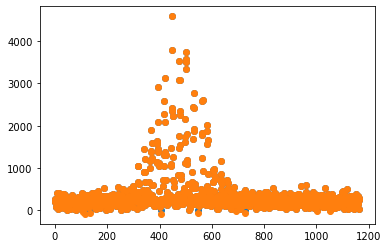

In [142]:
arr = invTrainWF[3085221:3086386]
head = np.mean(arr[:, :100], axis=1)
tail = np.mean(arr[:, -100:], axis=1)
base = np.minimum(head, tail)
intWF0 = np.sum(arr, axis=1)-base*1000
plt.scatter(range(3086386-3085221),  (np.abs(intWF0)+intWF0)/2)
plt.scatter(range(3086386-3085221),  intWF0)
plt.show()

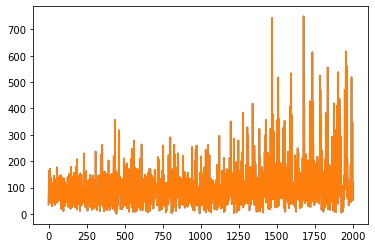

In [34]:
arr = invTrainWF[:2000]
head = np.mean(arr[:, :100], axis=1)
tail = np.mean(arr[:, -100:], axis=1)
base = np.minimum(head, tail)
intWF0 = np.sum(arr, axis=1)-base*1000
plt.plot(range(2000),  (np.abs(intWF0)+intWF0)/2)
plt.plot(range(2000),  intWF0)
plt.show()

In [135]:
np.argmin(intWF0)

2414

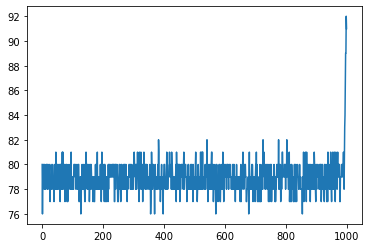

In [136]:
plt.plot(invTrainWF[2414])

In [85]:
j_tru[1007], j_tru[1008]

(3085221, 3086386)

In [17]:
X1

array([18971., 23288., 41752., ..., 10660., 12040., 11545.])